## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/tree/22f_basic/homeworks/lab02_deep_learning/sonnets.txt

path = '/content/drive/MyDrive/Colab_Notebooks/ranepa_mipt/ML/sonnets.txt'
with open(path, 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

--2022-12-25 14:14:35--  https://raw.githubusercontent.com/girafe-ai/ml-course/tree/22f_basic/homeworks/lab02_deep_learning/sonnets.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2022-12-25 14:14:35 ERROR 404: Not Found.



In [4]:
max([len(i) for i in text])

63

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [20]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = ''.join(text).lower()
assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [5]:
# !wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
# with open('onegin.txt', 'r') as iofile:
#     text = iofile.readlines()
    
# text = [x.replace('\t\t', '') for x in text]

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here


Put all the characters, that you've seen in the text, into variable `tokens`.

In [31]:
tokens = sorted(set(text))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [32]:
# dict <index>:<char>
# Your great code here
id_to_token = {idx: char for idx, char in enumerate(tokens)}
# dict <char>:<index>
# Your great code here
token_to_id = {char: idx for idx, char in enumerate(tokens)}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [45]:
import random

def text_to_matrix(text, max_lenght, batch_size):
  # max_lenght += 1
  batch_id = random.sample(range(len(text)-max_lenght), batch_size)
  data = np.array(list(map(lambda x: [token_to_id[char] for char in text[x:x+max_lenght]], batch_id)))
  return data

In [170]:
import torch, torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output


class VanillaRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x_emb = self.embedding(x)
        
        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation
        x_and_h = torch.cat([x_emb, h_prev], dim=-1)
        h_next = self.rnn_update(x_and_h)
        
        h_next = torch.tanh(h_next)
        
        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next)
        
        return h_next, logits
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)


def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logits = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logits_next = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logits.append(logits_next)
        
    return torch.stack(logits, dim=1)




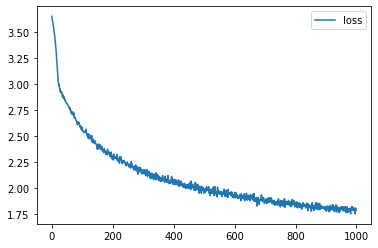

In [47]:
char_rnn = VanillaRNNCell()

opt = torch.optim.Adam(char_rnn.parameters())
loss_func = nn.CrossEntropyLoss()
history = []
batch_size = 32
MAX_LENGTH = 200
num_tokens = len(token_to_id)

for i in range(1000):
    batch_ix = text_to_matrix(text, MAX_LENGTH, batch_size)
    # batch_ix = text_to_matrix(sample(names, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    # compute loss
    #<YOUR CODE>
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = loss_func(
        predictions_logp.reshape((-1, num_tokens)),
        actual_next_tokens.reshape(-1)
    )
    
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [78]:
def generate_sample(char_rnn, seed_phrase=' Hello', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logits_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logits_next / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens, p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        # if next_ix == token_to_id['>']:
        #   break
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [79]:
print(generate_sample(char_rnn, seed_phrase = ' a', temperature = 0.6, max_length=200))

 am this i beash the i with on bearth gemest wime ulles disseed the prich shaor'd thou grine to the live sorer love thine thou grest the conce hus here be mise thou thou the shear growed you thet me a


In [80]:
# An example of generated text.
# print(generate_text(length=500, temperature=0.2))

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [230]:
num_tokens = len(token_to_id)

class LSTMLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=MAX_LENGTH, rnn_num_units=64, drop_prob=0.3, n_layers=1):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.lstm = nn.LSTM(emb_size, rnn_num_units, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.lstm_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev, c_0):
        x_emb = self.emb(x)
        out, h_next = self.lstm(x_emb, (h_prev,c_0))
        out = self.dropout(out)
        logits = self.lstm_to_logits(out)
        
        return h_next[0], h_next[1], logits
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(1, batch_size, self.num_units, requires_grad=True)

In [231]:
def lstm_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logits = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logits_next = char_rnn(x_t, hid_state, hid_state)  # <-- here we call your one-step code
        logits.append(logits_next)
        
    return torch.stack(logits, dim=1)


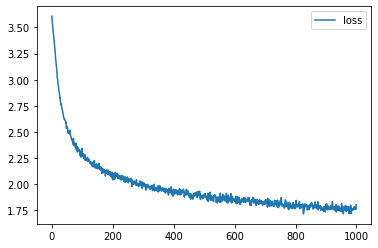

In [234]:
char_lstm = LSTMLoop()

opt = torch.optim.Adam(char_lstm.parameters())
loss_func = nn.CrossEntropyLoss()
history = []
batch_size = 32
MAX_LENGTH = 200

for i in range(1000):
    batch_ix = text_to_matrix(text, MAX_LENGTH, batch_size)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    h_0 = char_lstm.initial_state(batch_size = 32)
    hn, cn, logp_seq = char_lstm(batch_ix, h_0, h_0)
    
    predictions_logp = logp_seq[:, :-1]    
    actual_next_tokens = batch_ix[:, 1:]

    loss = loss_func(predictions_logp.contiguous().view(-1, num_tokens), 
                  actual_next_tokens.contiguous().view(-1))
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [237]:
# Text generation with different temperature values here
def generate_sample_lstm(model, seed_phrase=[' Hello'], max_length=MAX_LENGTH, temperature=1.0):
    '''    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([[x_sequence]], dtype=torch.int64)
    hid_state = model.initial_state(batch_size=1)

    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, cn, out = model(x_sequence[:, :,i], hid_state, hid_state)
        
    #start generating
    for _ in range(max_length - len(seed_phrase)):
#         print(x_sequence.shape, x_sequence, hid_state.shape)
        hid_state, cn, out = model(x_sequence[:, :,-1], hid_state, hid_state)
        
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0][0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens, p=p_next)
        next_ix = torch.tensor([[[next_ix]]], dtype=torch.int64)

        x_sequence = torch.cat([x_sequence, next_ix], dim=2)
    x_sequence = torch.flatten(x_sequence)
    
        
    return ''.join([id_to_token[ix] for ix in x_sequence.data.numpy()])

In [239]:
MAX_LENGTH = 200
for temp in [0.1, 0.2, 0.5, 1.0, 2.0]:
  print(temp)
  print(generate_sample_lstm(char_lstm, seed_phrase=[' '], temperature=temp))

0.1
 the and the a the with the the of the with the the the live the the me the the the love sund the with me the the the the with the the res the the surks with ness ight the the the ald the me the the t
0.2
 the with the keve the sunge the the more and the age with the the of my be the the with the the a ming the more the with more the will i the see the but the whe the surn the the self the the the love
0.5
 whe ast is your chast the nother eyes the her the a bothe bess both she the the the wear set her deing the love shick is xxi

  thes the face make bornguches sping the thouf in the strevend i mit,
  
1.0
 afil seck,
  trat'd, s rtanb'd's stranuse'd
  touiserther,
  sw qure the thath,
 is wous mout,
  otpo y morich'd
  uthin(g ared whance and qure?
  of benesto ey navap,
  and faak tmeay,
  thof hearch
2.0
 thathst,
  exxoula!. 
 i,
; f)cpo!
 (jo
-i-tuw:
   lalgy,
 s.
  akne,;(ns-dr my, fosiib
  nufbn ew;od,
n n.ilong
  swe cfifi?x

  noesit tinsagud.xi,
ibxll;
 
, ey' resce.r (t

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [244]:
# Saving and loading code here
PATH = '/content/drive/MyDrive/Colab_Notebooks/ranepa_mipt/ML/lstm.pt'
torch.save(char_lstm.state_dict(), PATH)

loaded_model = torch.load(PATH)
print(generate_sample_lstm(loaded_model, seed_phrase=[' '], temperature=0.1))

 the with the the the the love the ave the mare the me the me hathest the will has mine the of the surn the me the the the are the the the the the the the whe brest the with the the i hath the me the 


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)